In [1]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['HIP_VISIBLE_DEVICES'] = '0'

In [2]:
seed = 123
torch.manual_seed(seed)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
train_set = MNIST(root="../datasets", train=True, download=True, transform=transforms.ToTensor())
test_set = MNIST(root="../datasets", train=False, download=True, transform=transforms.ToTensor())

In [4]:
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super(AutoEncoder, self).__init__()

        self.encoder_layer1 = nn.Linear(28 * 28, 128, bias=False)
        self.encoder_bn1 = nn.BatchNorm1d(128)
        self.encoder_layer2 = nn.Linear(128, 64, bias=False)
        self.encoder_bn2 = nn.BatchNorm1d(64)
        self.encoder_layer3 = nn.Linear(64, 32, bias=False)
        self.encoder_bn3 = nn.BatchNorm1d(32)

        self.decoder_layer1 = nn.Linear(32, 64, bias=False)
        self.decoder_bn1 = nn.BatchNorm1d(64)
        self.decoder_layer2 = nn.Linear(64, 128, bias=False)
        self.decoder_bn2 = nn.BatchNorm1d(128)
        self.decoder_layer3 = nn.Linear(128, 28 * 28, bias=True)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    
    def forward(self, x):

        # encoder forward pass
        x = self.relu(self.encoder_bn1(self.encoder_layer1(x)))
        x = self.relu(self.encoder_bn2(self.encoder_layer2(x)))
        x = self.relu(self.encoder_bn3(self.encoder_layer3(x)))

        latent = x.detach().clone()

        # decoder forward pass
        x = self.relu(self.decoder_bn1(self.decoder_layer1(x)))
        x = self.relu(self.decoder_bn2(self.decoder_layer2(x)))
        x = self.sigmoid(self.decoder_layer3(x))

        return x, latent

In [6]:
model = AutoEncoder().to(DEVICE)

In [7]:
NUM_EPOCH = 40
LEARNING_RATE = 1e-4

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [8]:
min_loss = float('inf')
train_loss = []

for epoch in range(NUM_EPOCH):

    total_loss = 0

    for img, _ in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        img = img.view(-1, 1 * 28 * 28).to(DEVICE)
        out, latent = model(img)

        loss = criterion(out, img)

        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = total_loss / BATCH_SIZE
    train_loss.append(epoch_loss)

    print(f'Epoch: {epoch + 1} | Loss: {epoch_loss:.4f}')

    if epoch_loss < min_loss:
        torch.save(model.state_dict(), "./best_model.pth")
        torch.save(optimizer.state_dict(), "./optimizer_state.pth")
        min_loss = epoch_loss

Epoch 1: 100%|██████████| 938/938 [00:07<00:00, 118.54it/s]


Epoch: 1 | Loss: 1.2735


Epoch 2: 100%|██████████| 938/938 [00:07<00:00, 127.48it/s]


Epoch: 2 | Loss: 0.6019


Epoch 3: 100%|██████████| 938/938 [00:07<00:00, 127.57it/s]


Epoch: 3 | Loss: 0.4912


Epoch 4: 100%|██████████| 938/938 [00:07<00:00, 129.45it/s]


Epoch: 4 | Loss: 0.4322


Epoch 5: 100%|██████████| 938/938 [00:07<00:00, 127.80it/s]


Epoch: 5 | Loss: 0.3944


Epoch 6: 100%|██████████| 938/938 [00:07<00:00, 129.87it/s]


Epoch: 6 | Loss: 0.3666


Epoch 7: 100%|██████████| 938/938 [00:07<00:00, 129.80it/s]


Epoch: 7 | Loss: 0.3460


Epoch 8: 100%|██████████| 938/938 [00:07<00:00, 131.28it/s]


Epoch: 8 | Loss: 0.3286


Epoch 9: 100%|██████████| 938/938 [00:07<00:00, 132.24it/s]


Epoch: 9 | Loss: 0.3153


Epoch 10: 100%|██████████| 938/938 [00:07<00:00, 130.27it/s]


Epoch: 10 | Loss: 0.3035


Epoch 11: 100%|██████████| 938/938 [00:07<00:00, 127.32it/s]


Epoch: 11 | Loss: 0.2944


Epoch 12: 100%|██████████| 938/938 [00:07<00:00, 132.80it/s]


Epoch: 12 | Loss: 0.2860


Epoch 13: 100%|██████████| 938/938 [00:07<00:00, 130.73it/s]


Epoch: 13 | Loss: 0.2786


Epoch 14: 100%|██████████| 938/938 [00:07<00:00, 129.43it/s]


Epoch: 14 | Loss: 0.2717


Epoch 15: 100%|██████████| 938/938 [00:07<00:00, 127.90it/s]


Epoch: 15 | Loss: 0.2659


Epoch 16: 100%|██████████| 938/938 [00:07<00:00, 128.01it/s]


Epoch: 16 | Loss: 0.2601


Epoch 17: 100%|██████████| 938/938 [00:07<00:00, 131.10it/s]


Epoch: 17 | Loss: 0.2546


Epoch 18: 100%|██████████| 938/938 [00:07<00:00, 130.55it/s]


Epoch: 18 | Loss: 0.2498


Epoch 19: 100%|██████████| 938/938 [00:07<00:00, 130.21it/s]


Epoch: 19 | Loss: 0.2449


Epoch 20: 100%|██████████| 938/938 [00:07<00:00, 128.56it/s]


Epoch: 20 | Loss: 0.2405


Epoch 21: 100%|██████████| 938/938 [00:07<00:00, 128.64it/s]


Epoch: 21 | Loss: 0.2358


Epoch 22: 100%|██████████| 938/938 [00:07<00:00, 132.24it/s]


Epoch: 22 | Loss: 0.2321


Epoch 23: 100%|██████████| 938/938 [00:07<00:00, 129.50it/s]


Epoch: 23 | Loss: 0.2280


Epoch 24: 100%|██████████| 938/938 [00:07<00:00, 128.39it/s]


Epoch: 24 | Loss: 0.2240


Epoch 25: 100%|██████████| 938/938 [00:07<00:00, 132.59it/s]


Epoch: 25 | Loss: 0.2204


Epoch 26: 100%|██████████| 938/938 [00:07<00:00, 129.18it/s]


Epoch: 26 | Loss: 0.2172


Epoch 27: 100%|██████████| 938/938 [00:07<00:00, 129.20it/s]


Epoch: 27 | Loss: 0.2140


Epoch 28: 100%|██████████| 938/938 [00:07<00:00, 127.74it/s]


Epoch: 28 | Loss: 0.2112


Epoch 29: 100%|██████████| 938/938 [00:07<00:00, 128.92it/s]


Epoch: 29 | Loss: 0.2080


Epoch 30: 100%|██████████| 938/938 [00:07<00:00, 127.46it/s]


Epoch: 30 | Loss: 0.2044


Epoch 31: 100%|██████████| 938/938 [00:07<00:00, 128.81it/s]


Epoch: 31 | Loss: 0.2021


Epoch 32: 100%|██████████| 938/938 [00:07<00:00, 127.52it/s]


Epoch: 32 | Loss: 0.2001


Epoch 33: 100%|██████████| 938/938 [00:07<00:00, 128.81it/s]


Epoch: 33 | Loss: 0.1973


Epoch 34: 100%|██████████| 938/938 [00:07<00:00, 130.97it/s]


Epoch: 34 | Loss: 0.1949


Epoch 35: 100%|██████████| 938/938 [00:07<00:00, 130.51it/s]


Epoch: 35 | Loss: 0.1923


Epoch 36: 100%|██████████| 938/938 [00:07<00:00, 130.21it/s]


Epoch: 36 | Loss: 0.1903


Epoch 37: 100%|██████████| 938/938 [00:07<00:00, 128.28it/s]


Epoch: 37 | Loss: 0.1878


Epoch 38: 100%|██████████| 938/938 [00:07<00:00, 123.22it/s]


Epoch: 38 | Loss: 0.1858


Epoch 39: 100%|██████████| 938/938 [00:07<00:00, 125.73it/s]


Epoch: 39 | Loss: 0.1836


Epoch 40: 100%|██████████| 938/938 [00:07<00:00, 126.32it/s]

Epoch: 40 | Loss: 0.1815


## Plotting the train loss curve

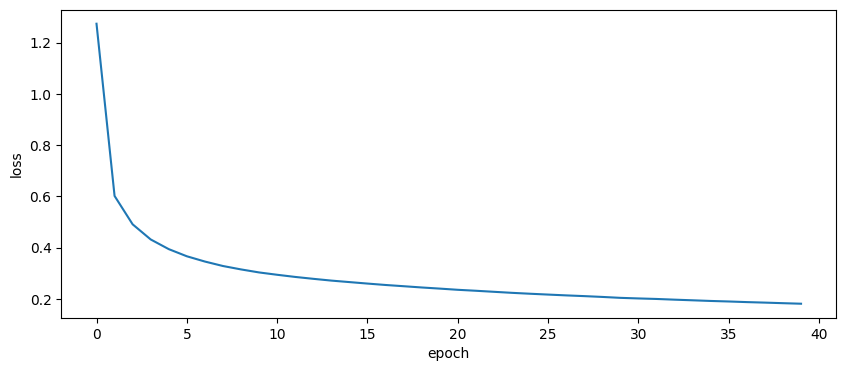

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [10]:
best_model = AutoEncoder().to(DEVICE)
best_model.load_state_dict(torch.load("./best_model.pth", weights_only=True, map_location=DEVICE))

<All keys matched successfully>

In [11]:
best_model.eval()

with torch.no_grad():
    i = 1
    for true_imgs, _ in tqdm(test_loader):
        true_imgs = true_imgs.view(-1, 1 * 28 * 28).to(DEVICE)
        preds, _ = best_model(true_imgs)
        preds = preds.view(-1, 28, 28).cpu()

        for pred, true_img in zip(preds, true_imgs):
            if i % 100 == 0:
                save_image(pred, f'./generated_images/{i}_predicted.png')
                save_image(true_img.view(1, 28, 28).cpu(), f'./generated_images/{i}_original.png')

            i += 1

100%|██████████| 1000/1000 [00:01<00:00, 553.73it/s]


In [12]:
latent_vectors = []
labels = []

for images, targets in tqdm(test_loader):
    images = images.view(-1, 1 * 28 * 28).to(DEVICE)  # Flatten the images
    _, latent = model(images)                         # Get latent vectors
    latent_vectors.extend(latent.cpu())
    labels.extend(targets)

100%|██████████| 1000/1000 [00:01<00:00, 509.98it/s]


In [13]:
latent_2d = TSNE(n_components=2).fit_transform(np.array(latent_vectors))

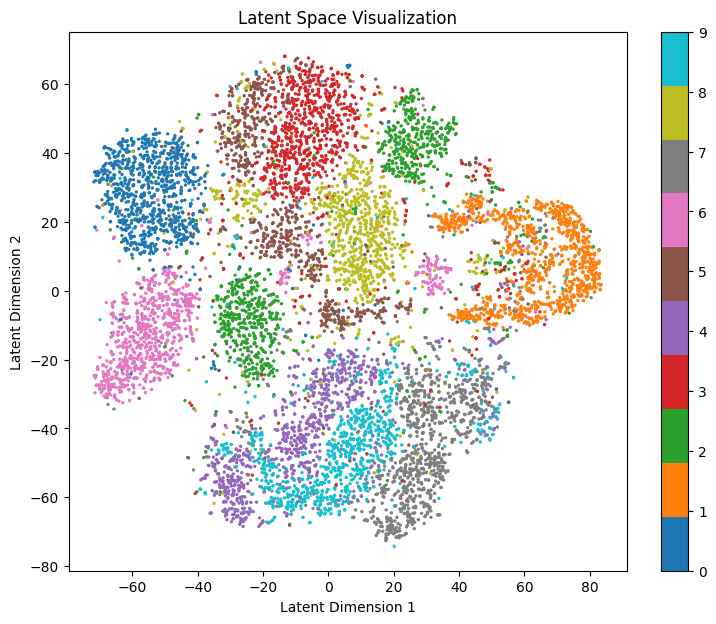

In [14]:
plt.figure(figsize=(9, 7))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=2)
plt.colorbar()
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()